In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import pickle

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import exoplanet as xo
import glob
import pymc3_ext as pmx
import lightkurve as lk
from celerite2.theano import terms, GaussianProcess

In [2]:
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from transit_model import build_model

In [4]:
df = pd.read_csv("../data/catalogues/berger_2020.tsv", delimiter='\t')
candidates = pd.read_csv("candidates.csv", delimiter='\t')
kicid = [
#     9471419,
    8249829,
    7767699,
    5724523,
    4380834,
    9895543
#     '11666429'
#     '12116239'
]
candidates = candidates[candidates.kic.isin(kicid)]
df = df.merge(candidates, left_on='KIC', right_on='kic')

In [5]:
# from astroquery.mast import Observations, Catalogs

# result = Catalogs.query_criteria(catalog="Tic", KIC=df.kic.values).to_pandas()
# result['KIC'] = result['KIC'].astype(str)

# df = pd.merge(result, df, left_on='KIC', right_on='kic')
# df.kic

In [6]:
# ii = 2
# row = df.iloc[ii]
# f = glob.glob(f"../prewhitening/results/spline and BIC/prewhitened/*{row.kic}*")[0]
# time, flux, flux_err = np.loadtxt(f, unpack=True)
# lc = lk.LightCurve(time, flux + 1., flux_err)
# lc = lc.flatten(window_length=201, break_tolerance=11).remove_outliers(sigma_upper=5, sigma_lower=5)
# time, flux, flux_err = lc.time.value, lc.flux.value, lc.flux_err.value
# flux_err /= 1e3
# flux -= 1.

# m = np.ones_like(time, dtype=bool)
# ref_time = 0.5 * (np.min(time) + np.max(time))
# x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
# y = np.ascontiguousarray(flux[m], dtype=np.float64)
# yerr = np.ascontiguousarray(flux_err[m], dtype=np.float64)
# #
# plt.plot(x, y, ".k")
# plt.xlabel("time [days]")
# plt.ylabel("relative flux [ppt]")
# _ = plt.xlim(x.min(), x.max())


# texp = np.min(np.diff(x))

In [7]:
df

,KIC,Mass,E_Mass,e_Mass,Teff,E_Teff,e_Teff,logg,E_logg,e_logg,...,Dist,E_Dist,e_Dist,Avmag,GOF,TAMS,kic,period,t0,bls_depth
0,4380834,1.442,0.075,-0.066,6775.0,139.4,-146.5,4.161,0.038,-0.038,...,1305.5,47.3,-45.7,0.530,1.0000,2.90,4380834,0.889871,-729.138777,0.200316
1,5724523,2.027,0.092,-0.092,7779.0,185.2,-180.0,3.842,0.034,-0.033,...,1874.0,65.9,-61.6,0.947,0.9914,1.05,5724523,0.545737,-735.105918,0.016599
2,7767699,1.786,0.088,-0.084,8059.8,211.1,-183.4,4.076,0.034,-0.033,...,874.1,23.0,-21.8,0.341,0.9992,1.37,7767699,1.128280,-734.116164,0.008033
3,8249829,1.668,0.090,-0.091,7487.6,163.1,-167.5,4.085,0.041,-0.042,...,1953.6,83.7,-80.5,0.721,1.0000,1.78,8249829,1.012885,-58.896685,0.161843
4,9895543,1.823,0.088,-0.083,7806.7,193.1,-184.1,4.040,0.035,-0.035,...,1241.1,40.6,-38.1,0.403,0.9963,1.40,9895543,1.218882,-734.346207,0.020572


# Begin

In [81]:
row = df.iloc[3]
with open(f'traces/{row.kic}.pkl', 'rb') as f:
    res = pickle.load(f)
    
bls_period = row.period
bls_t0 = row.t0
bls_depth = row.bls_depth# / 1e3

x = res['time']
y = res['flux']
# y = low_pass(x, y)
texp = np.min(np.diff(x))
mask = res['mask']
trace = res['trace']

# def build_model(mask=None, start=None, optimize=False):
#     if mask is None:
#         mask = np.ones(len(x), dtype=bool)
optimize=False
start=None


In [82]:

with pm.Model() as model:

    # Parameters for the stellar properties
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    u_star = xo.QuadLimbDark("u_star")

    # Orbital parameters for the planets
    log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
    t0 = pm.Normal("t0", mu=bls_t0, sd=1)
    log_ror = pm.Normal(
        "log_ror", mu=0.5 * np.log(bls_depth * 1e-3), sigma=10.0
    )
    ror = pm.Deterministic("ror", tt.exp(log_ror))

    period = pm.Deterministic("period", tt.exp(log_period))
    b = xo.distributions.ImpactParameter("b", ror=ror)

    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    dur = pm.Deterministic("dur", tt.exp(log_dur))

    # Transit jitter & GP parameters
    log_sigma_lc = pm.Normal(
        "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
    )
    log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
    log_sigma_gp = pm.Normal(
        "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
    )


    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
        period=period,
        t0=t0,
        b=b,
        duration=dur
    )


    # Compute the model light curve
    light_curves = pm.Deterministic(
        "light_curves",
        xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=ror, t=x[mask], 
            texp=texp
        )
        * 1e3,
    )
    light_curve = tt.sum(light_curves, axis=-1) + mean
    resid = y[mask] - light_curve

    # GP model for the light curve
    kernel = terms.SHOTerm(
        sigma=tt.exp(log_sigma_gp),
        rho=tt.exp(log_rho_gp),
        Q=1 / np.sqrt(2),
    )
    gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
    gp.marginal("gp", observed=resid)
    pm.Deterministic("gp_pred", gp.predict(resid))

    # Fit for the maximum a posteriori parameters, I've found that I can get
    # a better solution by trying different combinations of parameters in turn
    if start is None:
        start = model.test_point
    if optimize:
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[dur, log_ror])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[dur, log_ror])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
#         map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[dur])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)
    else:
        map_soln = start

#     return model, map_soln

In [83]:

# # mask = np.ones_like(x, dtype=bool)
# model, _ = build_model(mask=mask, optimize=False)

f = glob.glob(f"../prewhitening/results/spline and BIC/prewhitened/*{row.kic}*")[0]
time, flux, flux_err = np.loadtxt(f, unpack=True)
ref_time = 0.5 * (np.min(time) + np.max(time))

In [84]:
a_all = []
with model:
    for samp in xo.get_samples_from_trace(trace, 500):
        a_all.append(xo.eval_in_model(orbit.a, samp))
a_all = np.array(a_all)

In [85]:
import astropy.units as u
import astropy.constants as const

print(row.kic, end = ' & ')
trace = res['trace']
cols = ['period', 't0', 'dur', 'ror']
for col in cols:
    if col == 't0': 
        perc = np.percentile(trace[col] + ref_time, [16, 50, 84])
    elif col == 'ror':
        perc = np.percentile((trace[col] * row.Rad * u.R_sun).to(u.R_earth).value, [16, 50, 84])
    else:
        perc = np.percentile(trace[col], [16, 50, 84])
    print(f"${perc[1]:.6f}^{{+{perc[2]-perc[1]:.6f}}}_{{-{perc[1]-perc[0]:.6f}}}$", end=' & ')

perc = np.percentile(a_all / row.Rad, [16, 50, 84])
print(f"${perc[1]:.6f}^{{+{perc[2]-perc[1]:.6f}}}_{{-{perc[1]-perc[0]:.6f}}}$", end=' & ')
    
rho_calc = (3*(row.Mass * u.M_sun).to(u.kg)) / (4*np.pi*(row.Rad * u.R_sun).to(u.m)**3)
rho = ((3 * ((trace['period'] * u.day).to(u.s))) / (((trace['dur']*u.day).to(u.s))**3 * np.pi**2 * const.G)).value
perc = np.percentile(rho / rho_calc.value, [16, 50, 84])
print(f"${perc[1]:.3f}$", end = '\\\\')

8249829 & $1.012738^{+0.000112}_{-0.000094}$ & $1472.679212^{+0.006472}_{-0.008659}$ & $0.089623^{+0.009040}_{-0.007482}$ & $2.777522^{+0.367444}_{-0.257747}$ & $1.593047^{+0.292355}_{-0.503007}$ & $2.608$\\

In [86]:
np.median(rho)

858.299147339664

In [87]:
np.median(rho_calc)

<Quantity 329.13835096 kg / m3>

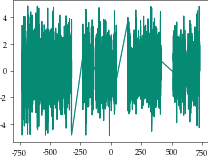

In [56]:
plt.plot(x[mask], y[mask] - np.median(trace['gp_pred']))
plt.plot(x[mask], y[mask], alpha=0.5)

In [48]:
row.kic

9895543

In [10]:
np.median(trace['ror']), print(np.median(trace['period']))

0.5457807212493386


(0.0038813358472498693, None)

In [11]:
print(row.ra), print(row.dec)

296.852564979529
40.9906221006223


(None, None)

In [12]:
mags = ['J', 'H', 'K']
for mag in mags:
    print(f'{mag} = {row[mag + "mag"]}, {row["e_" + mag + "mag"]}')

J = 12.384, 0.022
H = 12.232, 0.024
K = 12.17, 0.027


In [13]:
print(row.Teff, row.e_Teff)
print(row.FeHi, row.e_FeHi)
print(row.new_logg, row.new_logg_std)
# print(row.new_radius, row.rad)

7918.55 131.28
-0.18 0.3
3.67 0.1


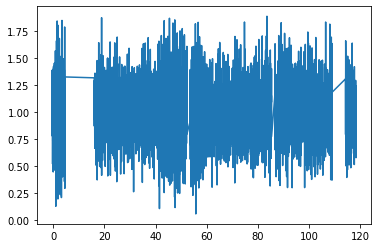

In [22]:
plt.plot(x[mask] - np.median(trace['t0']), y[mask] - np.median(trace['gp_pred'], axis=0)+1)

In [23]:
np.median(trace['t0'])

-58.88005119237792

In [24]:
# np.savetxt(f'vespa/{row.kic}/transit.txt', list(zip(x[mask] - np.median(trace['t0']),
#                                                  y[mask] - np.median(trace['gp_pred'],axis=0)+1)
#                                             ))

<Quantity 322.69382966 kg / m3>

In [98]:
import arviz as az

with model:
    trace = az.from_pymc3(res['trace'])

flat_samps = trace.posterior.stack(sample=("chain", "draw"))

In [79]:
plt.style.use('science')

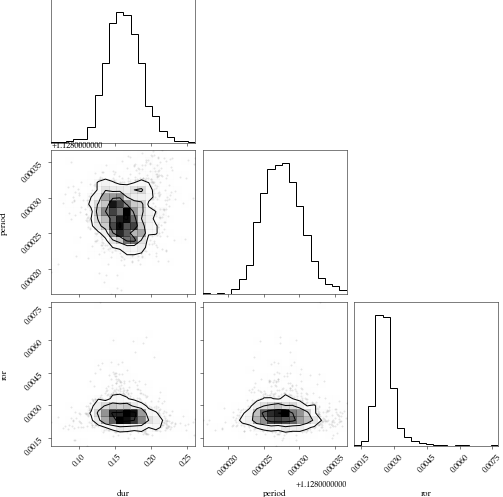

In [46]:
import corner

corner.corner(trace, var_names=['dur', 'period', 'ror']);

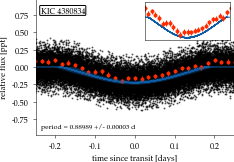

In [101]:
plt.subplots(figsize=[3.5625, 2.5
#                       2.2017460849215005
                     ])


flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = np.median(
    flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
)

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000,ms=2, rasterized=True, alpha=0.5)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
digit = np.digitize(x_fold, bins)
binerr = np.array([np.std(y[mask][digit == i]) / np.sqrt(len(x_fold[digit == i])) for i in range(len(bins)-1)])
plt.errorbar(
         0.5 * (bins[1:] + bins[:-1]), num / denom,yerr=binerr, fmt='o', color="C3", label="binned", ms=3, rasterized=True
)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = np.percentile(
    flat_samps["light_curves"][inds, 0], [16, 50, 84], axis=-1
)
plt.plot(x_fold[inds], pred[1], color="C0", label="model", rasterized=True)
art = plt.fill_between(
    x_fold[inds], pred[0], pred[2], color="C0", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")


# plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
# _ = plt.xlim(-0.4, 0.4)

dur_tot = np.median(flat_samps['dur'])
lim = 1.2*dur_tot
if lim > 0.25:
    lim = 0.25
plt.xlim(-1*lim, 1*lim)
# plt.xlim(-0.15, 0.15)
plt.ylim(-1*np.std(y), 1*np.std(y))


txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=7,
)
plt.annotate(f'KIC {row.kic}', (0.025,0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), fontsize=8)

# # INSET
ax = plt.gca()
axins = ax.inset_axes([0.55, 0.7, 0.43, 0.28])
axins.plot(x_fold[inds], pred[1], color="C0", label="model")
axins.errorbar(
         0.5 * (bins[1:] + bins[:-1]), num / denom,yerr=binerr, fmt='o', color="C3", label="binned", ms=3
)
axins.set_xlim(-0.2, 0.2)
axins.set(xticks=[], yticks=[])

plt.savefig(f'paper/{row.kic}.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# plt.subplots(figsize=[3.5625, 2.2017460849215005])


# flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# # Compute the GP prediction
# gp_mod = np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# # Get the posterior median orbital parameters
# p = np.median(flat_samps["period"])
# t0 = np.median(flat_samps["t0"])

# # Plot the folded data
# x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
# plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000,ms=2, rasterized=True, alpha=0.5)

# # Overplot the phase binned light curve
# bins = np.linspace(-0.41, 0.41, 50)
# denom, _ = np.histogram(x_fold, bins)
# num, _ = np.histogram(x_fold, bins, weights=y[mask])
# denom[num == 0] = 1.0
# digit = np.digitize(x_fold, bins)
# binerr = np.array([np.std(y[mask][digit == i]) / np.sqrt(len(x_fold[digit == i])) for i in range(len(bins)-1)])
# plt.errorbar(
#          0.5 * (bins[1:] + bins[:-1]), num / denom,yerr=binerr, fmt='o', color="C3", label="binned", ms=3
# )

# # Plot the folded model
# inds = np.argsort(x_fold)
# inds = inds[np.abs(x_fold)[inds] < 0.3]
# pred = np.percentile(
#     flat_samps["light_curves"][inds, 0], [16, 50, 84], axis=-1
# )
# plt.plot(x_fold[inds], pred[1], color="C0", label="model")
# art = plt.fill_between(
#     x_fold[inds], pred[0], pred[2], color="C0", alpha=0.5, zorder=1000
# )
# art.set_edgecolor("none")


# # plt.legend(fontsize=10, loc=4)
# plt.xlim(-0.5 * p, 0.5 * p)
# plt.xlabel("time since transit [days]")
# plt.ylabel("relative flux [ppt]")
# # _ = plt.xlim(-0.4, 0.4)

# dur_tot = np.median(flat_samps['dur'])
# lim = 1.2*dur_tot
# if lim > 0.25:
#     lim = 0.25
# plt.xlim(-1*lim, 1*lim)
# # plt.xlim(-0.15, 0.15)
# plt.ylim(-3*np.std(y), 3*np.std(y))


# txt = "period = {0:.5f} +/- {1:.5f} d".format(
#     np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
# )
# plt.annotate(
#     txt,
#     (0, 0),
#     xycoords="axes fraction",
#     xytext=(5, 5),
#     textcoords="offset points",
#     ha="left",
#     va="bottom",
#     fontsize=7,
# )
# plt.annotate(f'KIC {row.kic}', (0.025,0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), fontsize=8)


# # plt.savefig(f'paper/{row.kic}.pdf', dpi=300, bbox_inches='tight')

In [60]:
import astropy.units as u
import astropy.constants as const

P = (np.mean(flat_samps['period'].values) * u.day).to(u.s)
T = (np.mean(flat_samps['dur'].values) * u.day).to(u.day).to(u.s)

In [61]:
(3 * P) / (np.pi**2 * const.G * T**3)

<Quantity 837.4734816 kg / m3>

In [62]:
(3*(row.new_mass * u.M_sun).to(u.kg)) / (4*np.pi*(row.new_radius * u.R_sun).to(u.m)**3)

<Quantity 187.93334204 kg / m3>

In [284]:
(3*(1.5 * u.M_sun).to(u.kg)) / (4*np.pi*(2 * u.R_sun).to(u.m)**3)

<Quantity 264.33371706 kg / m3>

In [302]:
T = (np.linspace(0, 1, 100) * u.day).to(u.s)
P =( ((3*(1.5 * u.M_sun).to(u.kg)) / (4*np.pi*(2 * u.R_sun).to(u.m)**3)) * np.pi**2 * const.G * T**3 / 3).to(u.day)

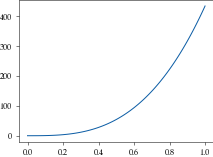

In [303]:
plt.plot(T.to(u.day), P)

In [113]:
from astropy.timeseries import LombScargle

def amplitude_spectrum(t, y, fmin=None, fmax=None, freq=None, oversample_factor=10.0):
    """ 
    Calculates the amplitude spectrum of a given signal
    
    Parameters
    ----------
        t : `array`
            Time values 
        y : `array`
            Flux or magnitude measurements
        fmin : float (default None)
            Minimum frequency to calculate spectrum. Defaults to df
        fmax : float
            Maximum frequency to calculate spectrum. Defaults to Nyquist.
        oversample_factor : float
            Amount by which to oversample the spectrum. Defaults to 10.
    """
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult
    if freq is None:
        freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

def low_pass(t, y, width=3.):
    y_low = gaussian_filter(y, width)
    return y_low


In [114]:
from scipy.ndimage import gaussian_filter

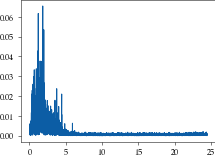

In [115]:
plt.plot(*amplitude_spectrum(x, low_pass(x, y)))
# plt.xlim(0,15)

# KOI table

In [88]:
koi_dsct = pd.read_csv('../pulsation timing/data/koi_dsct.csv')

In [127]:
# from astroquery.mast import Observations, Catalogs
df = pd.read_csv("../data/catalogues/berger_2020.tsv", delimiter='\t')

# result = Catalogs.query_criteria(catalog="Tic", KIC=koi_dsct.kepid).to_pandas()
# merged = pd.merge(result, koi_dsct, left_on='KIC', right_on='kepid', how='left')
merged = pd.merge(koi_dsct, df, left_on='kepid', right_on='KIC')

In [129]:
merged['koi_prad_jup'] = (merged['koi_prad'].values*u.R_earth).to(u.R_earth)
merged['koi_prad_jup_err1'] = (merged['koi_prad_err1'].values*u.R_earth).to(u.R_earth)
merged['koi_prad_jup_err2'] = (merged['koi_prad_err2'].values*u.R_earth).to(u.R_earth)
merged['koi_depth_ppt'] = merged['koi_depth'] / 1e3
merged['koi_depth_ppt_err1'] = merged['koi_depth_err1'] / 1e3
merged['koi_depth_ppt_err2'] = merged['koi_depth_err2'] / 1e3

merged['koi_duration_day'] = (merged['koi_duration'].values * (1 * u.hr).to(u.day)).value
merged['koi_duration_day_err1'] = (merged['koi_duration_err1'].values * (1 * u.hr).to(u.day)).value
merged['koi_duration_day_err2'] = (merged['koi_duration_err2'].values * (1 * u.hr).to(u.day)).value



In [152]:

merged['rho_ratio'] = np.array(((merged.koi_srho.values * u.g / u.cm**3).to(u.kg / u.m**3)).value) /  ((3*(merged.Mass.values * u.M_sun).to(u.kg)) / (4*np.pi*(merged.Rad.values * u.R_sun).to(u.m)**3)).value

In [159]:
columns = ['kepid', 'koi_period', 'koi_time0bk','koi_duration_day', 'koi_prad_jup', 'koi_dor']

for index, row in merged.iterrows():
    print(f"{row[columns[0]]}", end=' & ')
    for col in columns[1:]:
        print(f"${row[col]:.5f}^{{+{row[col + '_err1']:.5f}}}_{{{row[col + '_err2']:.5f}}}$", end = ' & ')
    print(f"${row.rho_ratio:.2f}$", end=' \\\\ \n ')

3964109 & $21.41624^{+0.00007}_{-0.00007}$ & $176.24991^{+0.00272}_{-0.00272}$ & $0.29504^{+0.00391}_{-0.00391}$ & $2.09000^{+0.38000}_{-0.23000}$ & $23.41300^{+0.44500}_{-0.44500}$ & $0.86$ \\ 
 9111849 & $63.07322^{+0.00029}_{-0.00029}$ & $191.25320^{+0.00354}_{-0.00354}$ & $0.22487^{+0.00508}_{-0.00508}$ & $17.80000^{+4.46000}_{-8.91000}$ & $62.80000^{+25.20000}_{-25.20000}$ & $3.77$ \\ 
 9845898 & $45.12622^{+0.00050}_{-0.00050}$ & $165.42066^{+0.00907}_{-0.00907}$ & $0.27733^{+0.01108}_{-0.01108}$ & $2.32000^{+0.76000}_{-0.25000}$ & $46.20000^{+17.00000}_{-17.00000}$ & $0.96$ \\ 
 5202905 & $22.82451^{+0.00023}_{-0.00023}$ & $144.46843^{+0.00848}_{-0.00848}$ & $0.27571^{+0.01250}_{-0.01250}$ & $3.36000^{+0.60000}_{-0.72000}$ & $25.77000^{+4.90000}_{-4.90000}$ & $0.94$ \\ 
 5202905 & $14.84448^{+0.00021}_{-0.00021}$ & $143.57600^{+0.01150}_{-0.01150}$ & $0.25379^{+0.01483}_{-0.01483}$ & $2.49000^{+0.44000}_{-0.54000}$ & $18.65000^{+7.20000}_{-7.20000}$ & $0.84$ \\ 
 6116172 & $69.6

In [161]:
10**0.3

1.9952623149688795

In [99]:
# from math import log10, floor
def round_to_1(x):
    try:
        n = -int(np.floor(np.log10(abs(x))))
        return np.round(x, n), n
    except:
        return np.nan, np.nan

In [137]:
columns = ['kepid', 'koi_period', 'koi_time0bk', 'koi_depth_ppt', 'koi_duration', 'koi_prad_jup']
col = columns[1]
for i in zip(merged[col], merged[col + '_err1'], merged[col + '_err2']):
    e1, n1 = round_to_1(i[1])
    e2, n2 = round_to_1(i[2])
    if np.isnan(e1) & np.isnan(e2):
        print(f'${i[0]:.4f}^{{+{e1}}}_{{{e2}}}$ \t')
    else:
        print(f'${np.round(i[0], np.nanmin([n1, n2]))}^{{+{e1}}}_{{{e2}}}$ \t')

$21.41624^{+7e-05}_{-7e-05}$ 	
$63.0732^{+0.0003}_{-0.0003}$ 	
$45.1262^{+0.0005}_{-0.0005}$ 	
$22.8245^{+0.0002}_{-0.0002}$ 	
$14.8445^{+0.0002}_{-0.0002}$ 	
$69.6468^{+nan}_{nan}$ 	
$111.6555^{+0.0007}_{-0.0007}$ 	
$86.1320^{+nan}_{nan}$ 	
$13.118962^{+6e-06}_{-6e-06}$ 	
$7.82187^{+2e-05}_{-2e-05}$ 	
$96.509^{+0.001}_{-0.001}$ 	
$1.0481^{+nan}_{nan}$ 	
$45.163^{+0.004}_{-0.004}$ 	
$72.282^{+0.001}_{-0.001}$ 	
$34.136^{+0.002}_{-0.002}$ 	
$44.114^{+0.001}_{-0.001}$ 	
$0.5331^{+nan}_{nan}$ 	


In [106]:
merged['']

<ipython-input-106-ddc8bdc2467c>:1: RuntimeWarning: All-NaN axis encountered
  np.nanmin([n1, n2])


nan

In [93]:
np.round(27.888, 5)

27.888

In [63]:
merged['tex_period'] = f'{merged['koi_period']}^{merged['koi_period_err1']}_^{merged['koi_period_err2']}'

SyntaxError: invalid syntax (<ipython-input-63-5bba4f80b9ed>, line 1)

# Koi dist

In [2]:
koi = pd.read_csv('cumulative_2021.05.01_20.40.11.csv', dtype={'kepid': str}, skiprows=146)
m = koi.koi_disposition != 'FALSE POSITIVE'
m &= koi.koi_prad < 200
koi = koi[m]

In [3]:
plt.style.use('science')

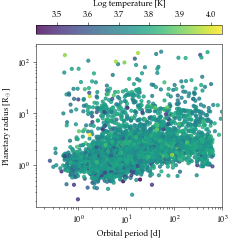

In [37]:
plt.figure(figsize=[3.3333, 3.7333])

m = (koi['koi_steff'] > 6500) & (koi['koi_steff'] < 10000)
plt.scatter(koi.koi_period, #koi.koi_prad, 
            koi.koi_prad,
            c=np.log10(koi.koi_steff), 
            s=10,alpha=0.8, rasterized=True)

# plt.plot(1.0726065,0.0038745,'.k')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Log temperature [K]', location='top')
plt.xlabel('Orbital period [d]')
plt.ylabel(r'Planetary radius [R$_\oplus$]')
plt.xlim(None, 10**3)

plt.savefig('koi_plot.pdf', dpi=300, bbox_inches='tight')